In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from glob import glob
import cv2
from tqdm.auto import tqdm
import os

gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu,enable=True)

In [100]:
DATA_DIR=r'C:/Users/2103099/Documents//kaggle_fungi/'
# for Colab
# DATA_DIR='./Omniglot'

train_data_path = os.path.join(DATA_DIR, "source/source/")
val_data_path = os.path.join(DATA_DIR, "target_s/target_s/")

batch_size = 32
val_batch_size = 20
epochs = 20
inner_lr = 0.02

n_way = 3
k_shot = 5
q_query = 1

input_shape = (64, 64, 1)
outer_lr = 0.0001

val_data_path

'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s/'

In [4]:
# training v.s test Omniglot classes
source_classes = glob(DATA_DIR+'source/source/*')
target_classes = glob(DATA_DIR+'/target_s/target_s/*')
print(f'字符種類 train: test = {len(source_classes)} : {len(target_classes)}')

字符種類 train: test = 300 : 110


In [5]:

# dataset 結構: images_background/語言/字符id
source_classes[:1]

target_classes [:1]

['C:/Users/2103099/Documents//kaggle_fungi//target_s/target_s\\10000_Abortiporus_biennis']

In [6]:
def __init__(self, data_path, batch_size, n_way=5, k_shot=3, q_query=1):
    """
    :param data_path: 資料夾下有子資料夾
    :param batch_size: 一個批次有多少個不同的task
    :param n_way: 一個task有幾類
    :param k_shot: 一個類別中有幾張圖片用於inner loop training
    :param q_query: 一個類別中有幾張圖片用於outer loop training
    """
    self.file_list = [f for f in glob(data_path + "**/*", recursive=True)]
    self.steps = len(self.file_list) // batch_size

    self.n_way = n_way
    self.k_shot = k_shot
    self.q_query = q_query
    self.meta_batch_size = batch_size

In [102]:
file_list = [f for f in glob(train_data_path + "**/?????_*", recursive=True)]
# file_list = [f for f in glob(val_data_path + "*/*", recursive=True)]
print(file_list)
print(train_data_path)
print(len(file_list))
steps = len(file_list) // batch_size
# print(steps)



img_dirs = random.sample(file_list, 3)

# print(len(img_dirs))
# # support_image = []
# # support_label = []
# # query_image = []
# # query_label = []



n_way = 3
k_shot = 4
q_query = 1
for label, img_dir in enumerate(img_dirs):
    print("imgdir",img_dir)
    img_list = [f for f in glob(img_dir + "**/*.JPG", recursive=True)]
    print(len(img_list))
    images = random.sample(img_list, k_shot + q_query)
    print(images)

['C:/Users/2103099/Documents//kaggle_fungi/source/source\\10059_Agaricus_bernardii', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\10065_Agaricus_campestris', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\10082_Agaricus_langei', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\10106_Agaricus_dulcidulus', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\10123_Agrocybe_dura', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\10127_Agrocybe_pediades', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\10227_Amanita_crocea', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\10266_Amanita_strobiliformis', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\10267_Amanita_submembranacea', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\10432_Antrodia_serialis', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\10559_Arrhenia_retiruga', 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\10561_Arrhenia_spathula

In [8]:
img_dirs

['C:/Users/2103099/Documents//kaggle_fungi/source/source\\12382_Cortinarius_croceus',
 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\14839_Cuphophyllus_fornicatus',
 'C:/Users/2103099/Documents//kaggle_fungi/source/source\\63564_Entoloma_sericeum']

In [9]:
img_dir

'C:/Users/2103099/Documents//kaggle_fungi/source/source\\63564_Entoloma_sericeum'

In [85]:
class MetaDataLoader:
    def __init__(self, data_path, batch_size, n_way=5, k_shot=1, q_query=1):
        """
        :param data_path: 資料夾下有子資料夾
        :param batch_size: 一個批次有多少個不同的task
        :param n_way: 一個task有幾類
        :param k_shot: 一個類別中有幾張圖片用於inner loop training
        :param q_query: 一個類別中有幾張圖片用於outer loop training
        """
        self.file_list = [f for f in glob(data_path + "**/?????_*", recursive=True)]
        self.steps = len(self.file_list) // batch_size

        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.meta_batch_size = batch_size

    def get_one_task_data(self):
        """
        取一個task, 有n_way類別,每類別有 k_shot於inner training, q_query張於outer training
        :return: support_data, query_data
        """
        img_dirs = random.sample(self.file_list, self.n_way)
        support_data = []
        query_data = []

        support_image = []
        support_label = []
        query_image = []
        query_label = []

        for label, img_dir in enumerate(img_dirs):
            img_list = [f for f in glob(img_dir + "**/*.JPG", recursive=True)]
            images = random.sample(img_list, self.k_shot + self.q_query)

            # Read support set
            for img_path in images[:self.k_shot]:
                image = cv2.imread(img_path)
                image = cv2.resize(image,(64,64),interpolation=cv2.INTER_CUBIC)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
                image = np.expand_dims(image, axis=-1)
                support_data.append((image, label))

            # Read query set
            for img_path in images[self.k_shot:]:
                image = cv2.imread(img_path)
                image = cv2.resize(image,(64,64),interpolation=cv2.INTER_CUBIC)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
                image = np.expand_dims(image, axis=-1)
                query_image.append(image)
                query_label.append(label)

        # shuffle support set
        random.shuffle(support_data)
        for data in support_data:
            support_image.append(data[0])
            support_label.append(data[1])

        # shuffle query set
        random.shuffle(query_data)
        for data in query_data:
            query_image.append(data[0])
            query_label.append(data[1])

        return np.array(support_image), np.array(support_label), np.array(query_image), np.array(query_label)

    def get_one_batch(self):
        """
        取一個batch, 以task為個體
        :return: k_shot_data, q_query_data
        """

        while True:
            batch_support_image = []
            batch_support_label = []
            batch_query_image = []
            batch_query_label = []

            for _ in range(self.meta_batch_size):
                support_image, support_label, query_image, query_label = self.get_one_task_data()
                batch_support_image.append(support_image)
                batch_support_label.append(support_label)
                batch_query_image.append(query_image)
                batch_query_label.append(query_label)

            yield np.array(batch_support_image), np.array(batch_support_label), \
                  np.array(batch_query_image), np.array(batch_query_label)

train_loader = MetaDataLoader(train_data_path, batch_size, n_way=n_way, k_shot=k_shot, q_query=q_query)
val_loader = MetaDataLoader(val_data_path, batch_size, n_way=n_way, k_shot=k_shot, q_query=q_query)

IndentationError: unexpected indent (<ipython-input-85-70de22c89237>, line 10)

In [59]:
print(val_data_path)

C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s/


In [60]:
print( batch_size)

32


In [56]:
val_loader = MetaDataLoader(val_data_path, batch_size, n_way=n_way, k_shot=k_shot, q_query=q_query)

['C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\10000_Abortiporus_biennis', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\10065_Agaricus_campestris', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\10994_Basidioradulum_radula', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\11085_Xerocomellus_porosporus', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\11086_Xerocomellus_pruinatus', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\11095_Hortiboletus_rubellus', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\11202_Buglossoporus_quercinus', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\11234_Calocera_viscosa', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\11384_Ceratiomyxa_fruticulosa', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\11573_Chalciporus_piperatus', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\11711_Clavariadelphus_pistilla

In [11]:
val_loader.steps

3

In [41]:
# support_imgs, support_labels, q_imgs, q_labels = train_loader.get_one_task_data()
support_imgs, support_labels, q_imgs, q_labels = val_loader.get_one_task_data()

In [13]:
support_labels

array([0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 1])

In [14]:
support_imgs.shape

(12, 64, 64, 1)

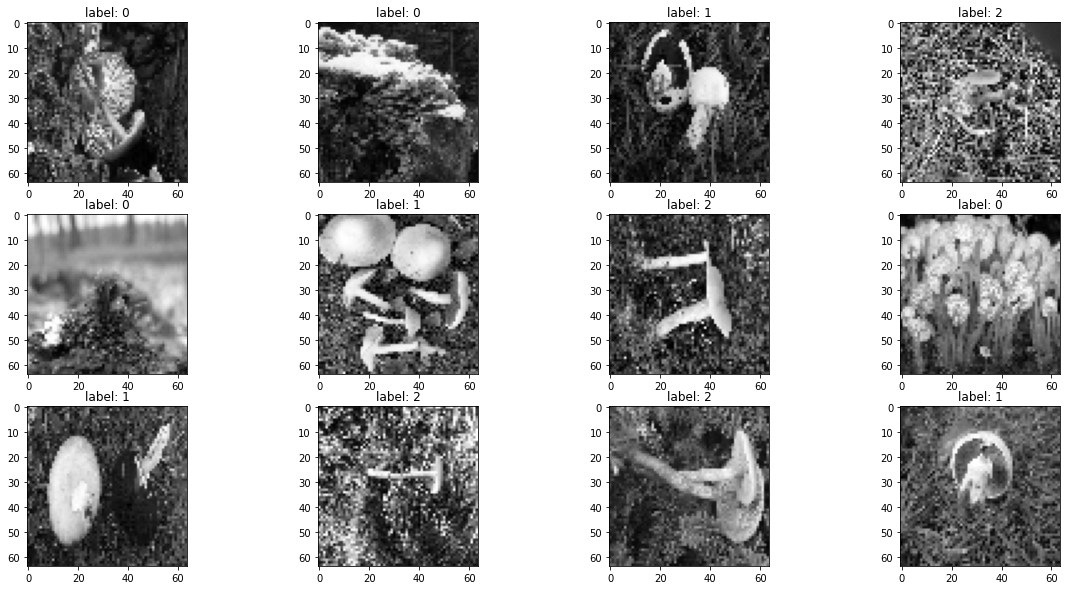

In [15]:

plt.figure(figsize=(20, 10))
for i in range(len(support_imgs)):
    plt.subplot(3, 4, i+1)
    plt.title(f'label: {support_labels[i]}')
    plt.imshow(support_imgs[i, :, :, 0], cmap='gray')
plt.show()


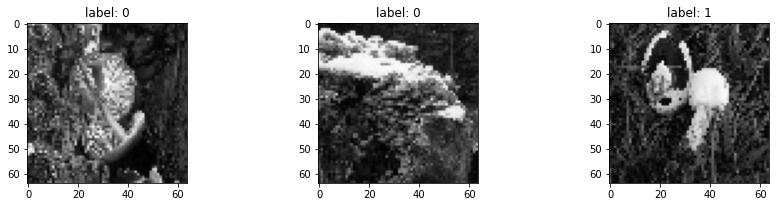

In [16]:

plt.figure(figsize=(20, 10))
for i in range(len(q_imgs)):
    plt.subplot(3, 4, i+1)
    plt.title(f'label: {support_labels[i]}')
    plt.imshow(support_imgs[i, :, :, 0], cmap='gray')
plt.show()


In [17]:

def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    return x


inputs = layers.Input(shape=(64, 64, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)

x = layers.Flatten()(x)
outputs = layers.Dense(n_way, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


inner_optimizer = keras.optimizers.Adam(learning_rate=inner_lr)
outer_optimizer = keras.optimizers.Adam(learning_rate=outer_lr)

model.compile(optimizer=inner_optimizer, 
              loss=keras.losses.sparse_categorical_crossentropy)

In [18]:
def maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=1, training=True):
    meta_support_image, meta_support_label, meta_query_image, meta_query_label = next(batch_data)
    batch_acc = []
    batch_loss = []

    for support_image, support_label, query_image, query_label in zip(meta_support_image, meta_support_label, meta_query_image, meta_query_label):
        # 保存一開始model weights
        meta_weights = model.get_weights()

        # inner loop training
        for _ in range(inner_step):
            with tf.GradientTape() as tape:
                logits = model(support_image, training=True)
                loss = keras.losses.sparse_categorical_crossentropy(support_label, logits)
                loss = tf.reduce_mean(loss)
            grads = tape.gradient(loss, model.trainable_variables)
            inner_optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # outer loop training: 計算query set loss
        with tf.GradientTape() as tape:
            logits = model(query_image, training=True)
            loss = keras.losses.sparse_categorical_crossentropy(query_label, logits)
            loss = tf.reduce_mean(loss)
            acc = (np.argmax(logits, -1) == query_label).astype(np.int32).mean()

            batch_loss.append(loss)
            batch_acc.append(acc)
        # 回復成一開始weights
        model.set_weights(meta_weights)
        
        
        # 在training set中需要更新 meta model
        if training:
            grads = tape.gradient(loss, model.trainable_variables)
            outer_optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return np.array(batch_loss).mean(), np.array(batch_acc).mean()



In [19]:
val_loader.steps

3

In [20]:
val_meta_loss = []
val_meta_acc = []
# Validation
for i in range(val_loader.steps):
    batch_data = val_loader.get_one_batch()
    batch_val_loss, batch_val_acc = maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=1, training=False)
    val_meta_loss.append(batch_val_loss)
    val_meta_acc.append(batch_val_acc)
print(val_meta_acc,val_meta_loss)

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333] [8.613517, 9.127048, 9.123269]


In [21]:
batch_data = val_loader.get_one_batch()
 
maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=3, training=True)

(2.6885087, 0.42708333333333326)

In [22]:
train_meta_loss = []
train_meta_acc = []
val_meta_loss = []
val_meta_acc = []

for meta_iter in tqdm(range(epochs)):
    # Training
    for i in tqdm(range(train_loader.steps), leave=False):
        batch_data = train_loader.get_one_batch() # batch_sup_img, batch_sup_label, batch_query_img, batch_query_label
        batch_train_loss, batch_train_acc = maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=1, training=True)
        train_meta_loss.append(batch_train_loss)
        train_meta_acc.append(batch_train_acc)
    # Validation
    for i in range(val_loader.steps):
        batch_data = val_loader.get_one_batch()
        batch_val_loss, batch_val_acc = maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=3, training=False)
        val_meta_loss.append(batch_val_loss)
        val_meta_acc.append(batch_val_acc)
    print(f'[epoch {meta_iter:05d}]: train_loss: {np.mean(train_meta_loss):.4f} val_loss: {np.mean(val_meta_loss):.4f} train_acc: {np.mean(train_meta_acc):.3f} val_acc: {np.mean(val_meta_acc):.3f}')


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00000]: train_loss: 9.4551 val_loss: 3.7036 train_acc: 0.341 val_acc: 0.340


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00001]: train_loss: 6.9661 val_loss: 3.9997 train_acc: 0.354 val_acc: 0.366


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00002]: train_loss: 5.1788 val_loss: 4.1211 train_acc: 0.350 val_acc: 0.373


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00003]: train_loss: 4.2887 val_loss: 4.2125 train_acc: 0.348 val_acc: 0.365


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00004]: train_loss: 3.7458 val_loss: 4.1842 train_acc: 0.346 val_acc: 0.361


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00005]: train_loss: 3.3699 val_loss: 4.2018 train_acc: 0.349 val_acc: 0.362


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00006]: train_loss: 3.1194 val_loss: 4.2539 train_acc: 0.345 val_acc: 0.368


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00007]: train_loss: 2.9302 val_loss: 4.2604 train_acc: 0.344 val_acc: 0.368


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00008]: train_loss: 2.7959 val_loss: 4.2754 train_acc: 0.344 val_acc: 0.370


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00009]: train_loss: 2.6763 val_loss: 4.3301 train_acc: 0.346 val_acc: 0.369


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00010]: train_loss: 2.5738 val_loss: 4.3233 train_acc: 0.347 val_acc: 0.371


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00011]: train_loss: 2.4823 val_loss: 4.3463 train_acc: 0.348 val_acc: 0.367


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00012]: train_loss: 2.4149 val_loss: 4.3411 train_acc: 0.347 val_acc: 0.368


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00013]: train_loss: 2.3530 val_loss: 4.3478 train_acc: 0.348 val_acc: 0.369


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00014]: train_loss: 2.2989 val_loss: 4.3428 train_acc: 0.347 val_acc: 0.369


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00015]: train_loss: 2.2591 val_loss: 4.3369 train_acc: 0.347 val_acc: 0.367


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00016]: train_loss: 2.2136 val_loss: 4.3499 train_acc: 0.346 val_acc: 0.367


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00017]: train_loss: 2.1742 val_loss: 4.3311 train_acc: 0.346 val_acc: 0.368


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00018]: train_loss: 2.1374 val_loss: 4.3404 train_acc: 0.345 val_acc: 0.366


  0%|          | 0/9 [00:00<?, ?it/s]

[epoch 00019]: train_loss: 2.1052 val_loss: 4.3199 train_acc: 0.345 val_acc: 0.367


In [23]:
# backup model weights
w = model.get_weights()
model.set_weights(w)


In [145]:
class MetaDataLoader2:
    def __init__(self, data_path, batch_size, n_way=5, k_shot=1, q_query=1):
        """
        :param data_path: 資料夾下有子資料夾
        :param batch_size: 一個批次有多少個不同的task
        :param n_way: 一個task有幾類
        :param k_shot: 一個類別中有幾張圖片用於inner loop training
        :param q_query: 一個類別中有幾張圖片用於outer loop training
        """
        self.file_list = data_path  #[f for f in glob(data_path + "**/?????_*", recursive=True)]
        self.steps = len(self.file_list) // batch_size

        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.meta_batch_size = batch_size

    def get_one_task_data(self):
        """
        取一個task, 有n_way類別,每類別有 k_shot於inner training, q_query張於outer training
        :return: support_data, query_data
        """
        img_dirs = random.sample(self.file_list, self.n_way)
        support_data = []
        query_data = []

        support_image = []
        support_label = []
        query_image = []
        query_label = []

        for label, img_dir in enumerate(img_dirs):
            img_list = [f for f in glob(img_dir + "**/*.JPG", recursive=True)]
            images = random.sample(img_list, self.k_shot + self.q_query)

            # Read support set
            for img_path in images[:self.k_shot]:
                image = cv2.imread(img_path)
                image = cv2.resize(image,(64,64),interpolation=cv2.INTER_CUBIC)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
                image = np.expand_dims(image, axis=-1)
                support_data.append((image, label))

            # Read query set
            for img_path in images[self.k_shot:]:
                image = cv2.imread(img_path)
                image = cv2.resize(image,(64,64),interpolation=cv2.INTER_CUBIC)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
                image = np.expand_dims(image, axis=-1)
                query_image.append(image)
                query_label.append(label)

        # shuffle support set
        random.shuffle(support_data)
        for data in support_data:
            support_image.append(data[0])
            support_label.append(data[1])

        # shuffle query set
        random.shuffle(query_data)
        for data in query_data:
            query_image.append(data[0])
            query_label.append(data[1])

        return np.array(support_image), np.array(support_label), np.array(query_image), np.array(query_label)

    def get_one_batch(self):
        """
        取一個batch, 以task為個體
        :return: k_shot_data, q_query_data
        """

        while True:
            batch_support_image = []
            batch_support_label = []
            batch_query_image = []
            batch_query_label = []

            for _ in range(self.meta_batch_size):
                support_image, support_label, query_image, query_label = self.get_one_task_data()
                batch_support_image.append(support_image)
                batch_support_label.append(support_label)
                batch_query_image.append(query_image)
                batch_query_label.append(query_label)

            yield np.array(batch_support_image), np.array(batch_support_label), \
                  np.array(batch_query_image), np.array(batch_query_label)

# train_loader = MetaDataLoader(train_data_path, batch_size, n_way=n_way, k_shot=k_shot, q_query=q_query)
# val_loader = MetaDataLoader(val_data_path, batch_size, n_way=n_way, k_shot=k_shot, q_query=q_query)

In [24]:

# read kaggle test1.csv file row by row
import csv
with open (r'C:/Users/2103099/Documents//kaggle_fungi/test1.csv',newline='') as csvfile:
    rows = csv.reader(csvfile)

    for row in rows:
        # restore model weights at the begining of adaptation
        model.set_weights(w)
#         print(row[0])
#         # each row is a task (3 way 1 shot) for adaptation
#         # read imgs and label (support_0: class 0, support_1: class 1, support_2: class 2)
        imgs, labels = (row[0],row[1:4])
        print(row[1:4])
#         # update model N times by (imgs, labels)

#         # use adapted model to predict img in "filename" column
        y_pred = model.predict(img_filename)
#         # get predict class and save to submission file

    

['support_0', 'support_1', 'support_2']


NameError: name 'img_filename' is not defined

In [ ]:
import pandas as pd
# read kaggle test1.csv file row by row
ans = pd.DataFrame(columns=['filename', 'ans'])
import csv
with open (r'C:/Users/2103099/Documents/kaggle_fungi/test1.csv',newline='') as csvfile:
    rows = csv.reader(csvfile)
    print(rows)

    for i, row in enumerate(rows):
#         print(i)
#        
        if i == 0:
            continue
        
        # restore model weights at the begining of adaptation
        model.set_weights(w)

        imgs, labels = (row[0],row[1:4])
        file_name = row[0]
        support_list = row[1:4]
#         print(support_list)
#         C:/Users/2103099/Documents//kaggle_fungi/target_s
        # update weight 10 times

        test_data_path = ["C:/Users/2103099/Documents/kaggle_fungi/target_s/target_s/"+i+"/" for i in support_list]
#         print(test_data_path)
# #         'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\10000_Abortiporus_biennis
        
        test_loader = MetaDataLoader2(test_data_path,1, n_way=3, k_shot=5, q_query=0)
        batch_data = test_loader.get_one_batch()
#         # train

        meta_support_image, meta_support_label, meta_query_image, meta_query_label = next(batch_data)
        model.fit(meta_support_image[0], meta_support_label[0], batch_size=1, epochs=30, validation_split=0.2, verbose=False)
        
        test_img = "C:/Users/2103099/Documents/kaggle_fungi/target_q/target_q/"+file_name
        image = cv2.imread(test_img)
#         print(image)
        image = cv2.resize(image,(64,64),interpolation=cv2.INTER_CUBIC)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
        image = np.expand_dims(image, axis=-1)
        image = np.array([image])

        y_pred = model.predict(np.array(image))
        res = np.argmax(y_pred)
        _ = {"filename": file_name, "ans": res}
        ans = ans.append(_, ignore_index=True)
        print(ans.tail(1), support_list[res])
#         print(ans.tail(1))
#         print(res)
#         print(type(support_list[res]))

        #用 pandas 產出分類結果
        submit = pd.DataFrame()
        submit['filename'] =file_name
        submit['ans'] = res
        sub = 'submission_meta_hw01.csv'
        submit.to_csv(sub,index=False)


                        filename ans
0  BEC2017-9189449_r1s5mHxpx.JPG   2 15527_Inonotus_obliquus
                   filename ans
1  HODDE2013PIC30468049.JPG   1 14845_Hygrocybe_insipida
                filename ans
2  AS2013PIC68471111.JPG   0 15626_Laccaria_bicolor
                      filename ans
3  JM2016-9165541_r1HMvecQ.JPG   0 63575_Chlorophyllum_olivieri
                        filename ans
4  DP2016-9181037_rklmIHiEge.JPG   0 13790_Entoloma_undatum
                        filename ans
5  PEL2017-9219500_r1BGeTisW.JPG   2 65211_Paxillus_ammoniavirescens
                        filename ans
6  AOJ2016-9181666_HkbZAzFll.JPG   1 20051_Russula_queletii
                 filename ans
7  JCS2013PIC20375320.JPG   1 15584_Kretzschmaria_deusta
                 filename ans
8  EAT2013PIC79981320.JPG   0 11384_Ceratiomyxa_fruticulosa
                        filename ans
9  TBE2017-9215485_Bk8XgsMjZ.JPG   2 15806_Lactarius_aurantiacus
                  filename ans
10  JAH2010PIC42001607.